# Emukit-Demo

In this example, we are going to showcase how we can do sensitivity analysis using a simple linear regression model.

In [1]:
from dataclasses import dataclass
from pathlib import Path

import autoroot
import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from bayesevt._src.utils.io import get_list_filenames
from utils import (
    interpolate_rectilinear_grid,
    plot_contour,
    plot_imshow,
    plot_pcolormesh,
)

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
%matplotlib inline
%load_ext autoreload
%autoreload 2

We can see that there is some explained variance that is missing.
Potentially we can explain this with the regression model.

## Load Data

We have a clean analysis-ready dataset available from the previous notebook.
We will save it and revisit it later.

First, we will make sure that the models in the covariates and the QoI are the same.

In [2]:
save_dir = Path("/pool/usuarios/juanjohn/data/ai4storylines/results/emukit")
save_name = Path("sobol_gp_results.nc")

ds = xr.open_dataset(save_dir.joinpath(save_name), engine="netcdf4")

In [25]:
ds

<xarray.Dataset> Size: 500kB
Dimensions:        (lat: 19, lon: 21, model: 27, covariate: 3)
Coordinates:
  * lat            (lat) float64 152B 26.25 28.75 31.25 ... 66.25 68.75 71.25
  * lon            (lon) float64 168B -20.0 -17.5 -15.0 -12.5 ... 25.0 27.5 30.0
  * model          (model) <U16 2kB 'access_cm2' ... 'ukesm1_0_ll'
    land_mask      (lat, lon) int16 798B 0 0 0 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0
  * covariate      (covariate) <U4 48B 'sst' 'sm' 'z500'
Data variables:
    tasmax         (model, lat, lon) float32 43kB 3.244 2.818 ... 8.945 8.988
    tasmax_norm    (model, lat, lon) float64 86kB 0.7069 0.6141 ... 1.587 1.595
    pred_mean      (model, lat, lon) float64 86kB 0.6798 0.6142 ... 1.509 1.555
    pred_var       (model) float64 216B ...
    grad_mean      (model, covariate, lat, lon) float64 259kB 0.9928 ... -0.0...
    grad_cov       (model, covariate) float64 648B ...
    main_effects   (covariate, lat, lon) float64 10kB -5.613 -6.074 ... 2.352
    total_effects  (covariate, lat, lon) float64 10kB 6.629 7.091 ... -1.49
    score          (lat, lon) float64 3kB 0.6141 0.4816 0.4112 ... 0.4468 0.4413
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.5 (https://mpi...
    source:                 ACCESS-CM2 (2019): \naerosol: UKCA-GLOMAP-mode\na...
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    ...                     ...
    variant_label:          r1i1p1f1
    version:                v20191108
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/9ecf99bf-2241-4c6a-acea-15d12be52c43
    license:                CMIP6 model data produced by CSIRO is licensed un...
    CDO:                    Climate Data Operators version 2.0.5 (https://mpi...

### R2 Score

In [4]:
from sklearn.metrics import r2_score

In [5]:
ds = ds.stack(spatial=["lat", "lon"])
score = r2_score(
    y_true=ds.tasmax_norm.values, y_pred=ds.pred_mean.values, multioutput="raw_values"
)
ds["score"] = (("spatial"), score)
ds = ds.unstack()

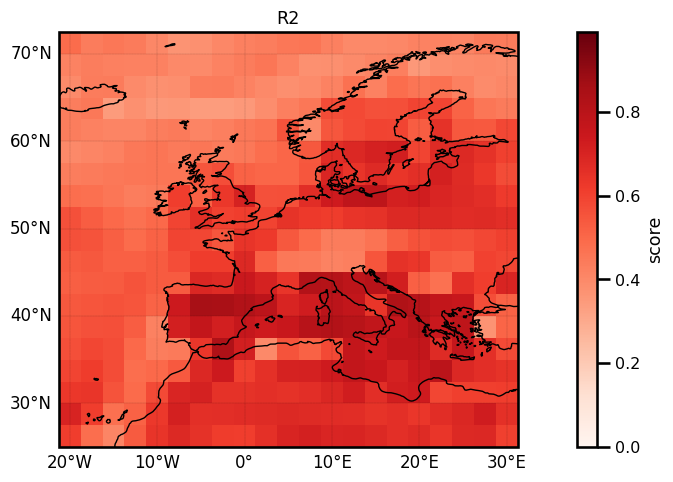

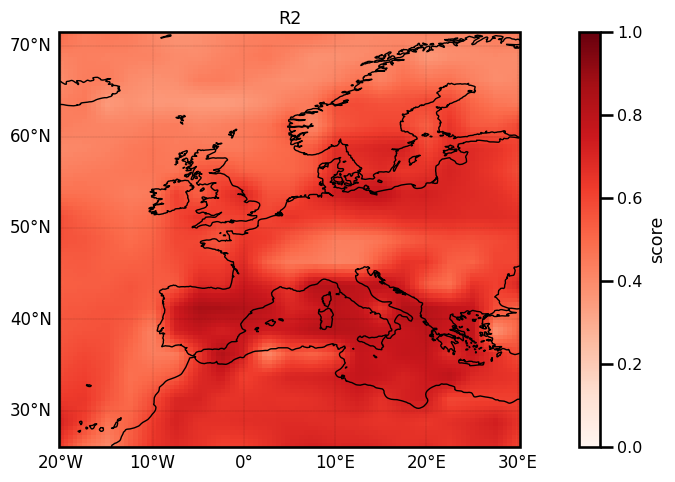

In [6]:
score = ds.score

plot_pcolormesh(
    score,
    "R2",
    vmin=0.0,
    vmax=0.99,
    cmap="Reds",
)

# interpolate
score = score.interp(
    lon=np.linspace(score.lon.values.min(), score.lon.values.max(), 100),
    lat=np.linspace(score.lat.values.min(), score.lat.values.max(), 100),
    method="linear",
)

plot_imshow(score, "R2", vmin=0.0, vmax=1.0, cmap="Reds", num_levels=None);

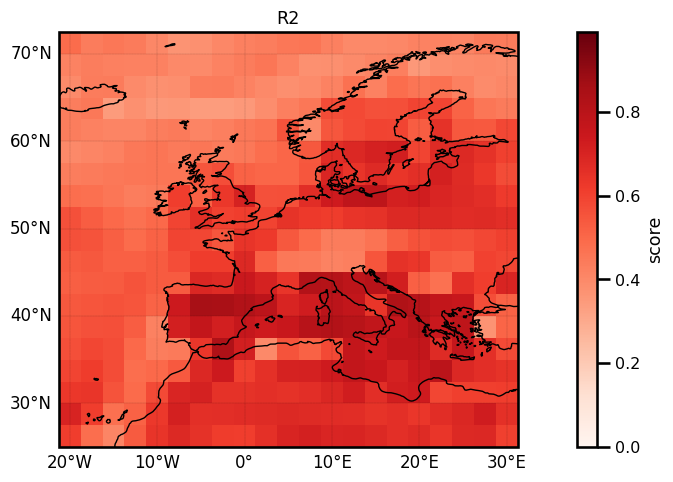

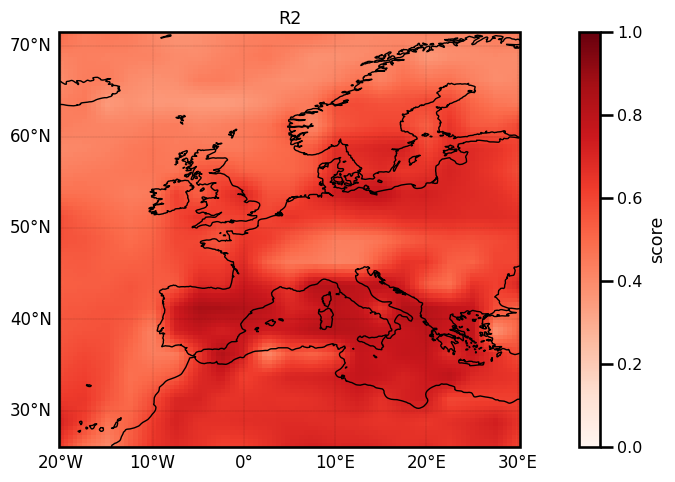

In [6]:
score = ds.score

plot_pcolormesh(
    score,
    "R2",
    vmin=0.0,
    vmax=0.99,
    cmap="Reds",
)

# interpolate
score = score.interp(
    lon=np.linspace(score.lon.values.min(), score.lon.values.max(), 100),
    lat=np.linspace(score.lat.values.min(), score.lat.values.max(), 100),
    method="linear",
)

plot_imshow(score, "R2", vmin=0.0, vmax=1.0, cmap="Reds", num_levels=None);

## Plot Maps

In [14]:
def plot_maps(covariate, variable_name, effects):

    # plot weights
    ds_subset = ds[effects].sel(covariate=covariate)

    ds_subset = np.abs(ds_subset)
    plot_pcolormesh(
        ds_subset, variable=variable_name, vmin=0.0, vmax=25, cmap="Reds"
    )

    # interpolate
    ds_subset = ds_subset.interp(
        lon=np.linspace(ds_subset.lon.values.min(), ds_subset.lon.values.max(), 100),
        lat=np.linspace(ds_subset.lat.values.min(), ds_subset.lat.values.max(), 100),
        method="linear",
    )

    plot_imshow(
        ds_subset, variable_name, vmin=0.0, vmax=25.0, cmap="Reds", num_levels=None
    );

### Sea Surface Temperature

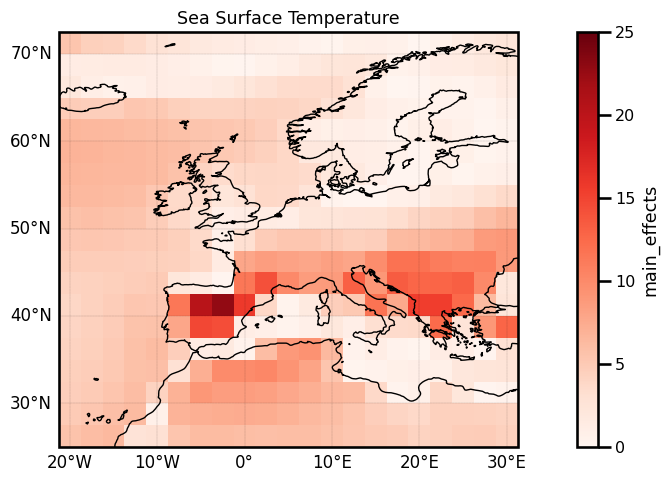

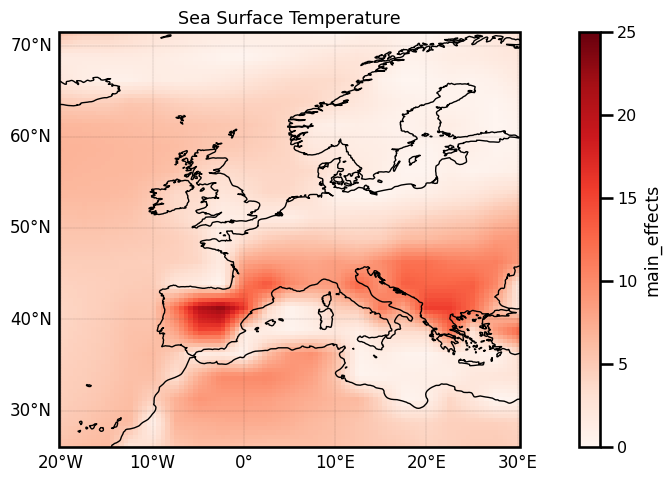

In [15]:
variable_name = "Sea Surface Temperature"
covariate = "sst"
effects = "main_effects"
plot_maps(covariate, variable_name, effects)

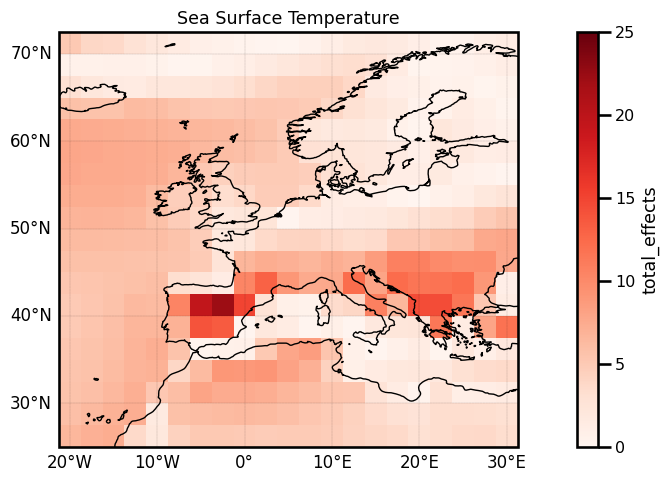

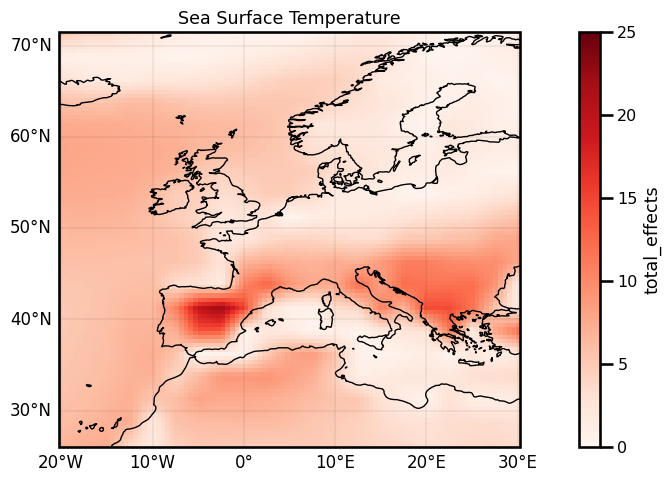

In [16]:
variable_name = "Sea Surface Temperature"
covariate = "sst"
effects = "total_effects"
plot_maps(covariate, variable_name, effects)

### Soil Moisture

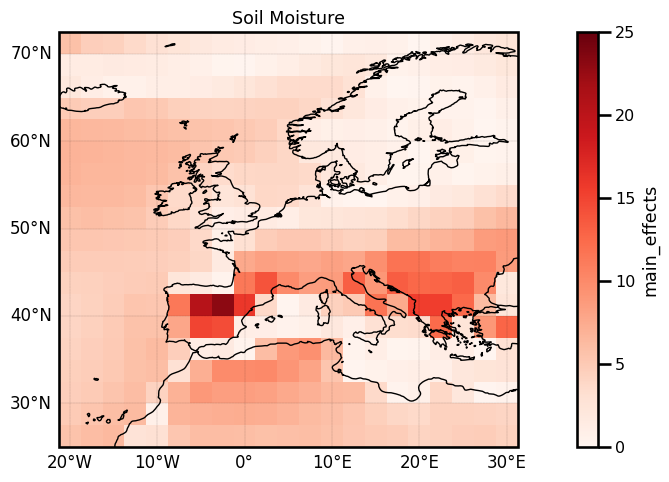

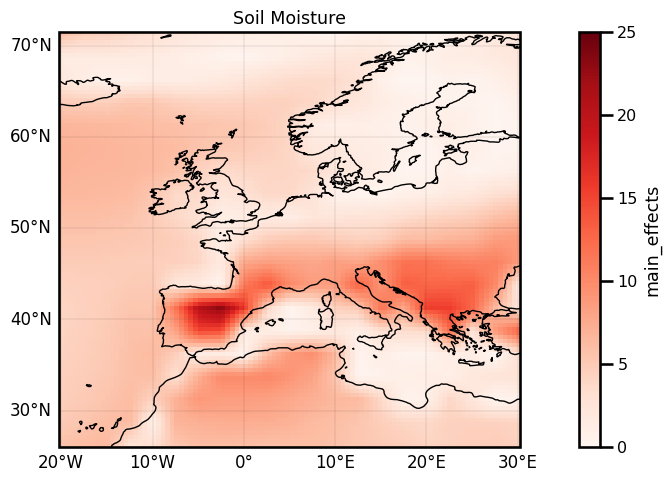

In [17]:
variable_name = "Soil Moisture"
covariate = "sm"
effects = "main_effects"
plot_maps(covariate, variable_name, effects)

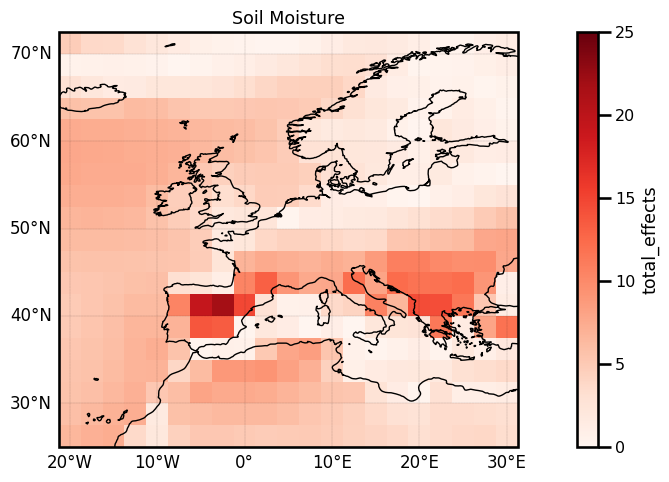

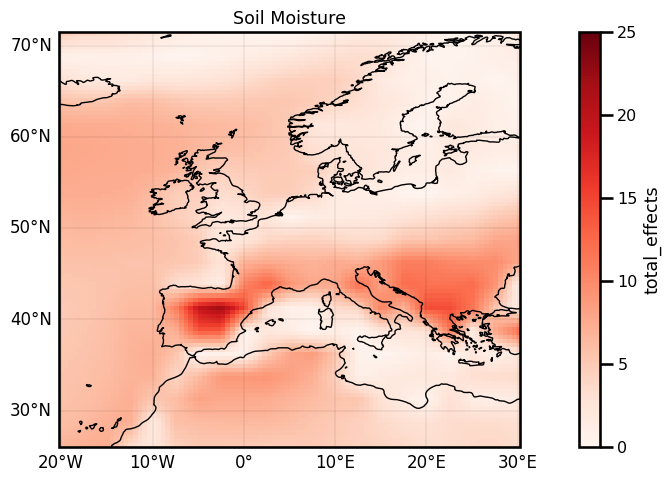

In [18]:
variable_name = "Soil Moisture"
covariate = "sm"
effects = "total_effects"
plot_maps(covariate, variable_name, effects)

### Geopotential

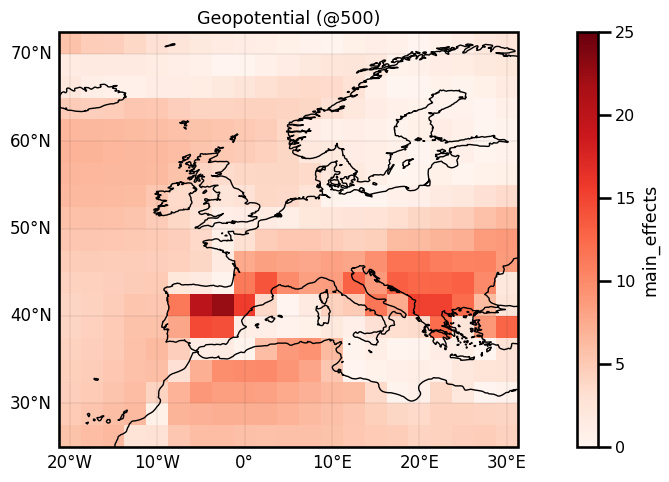

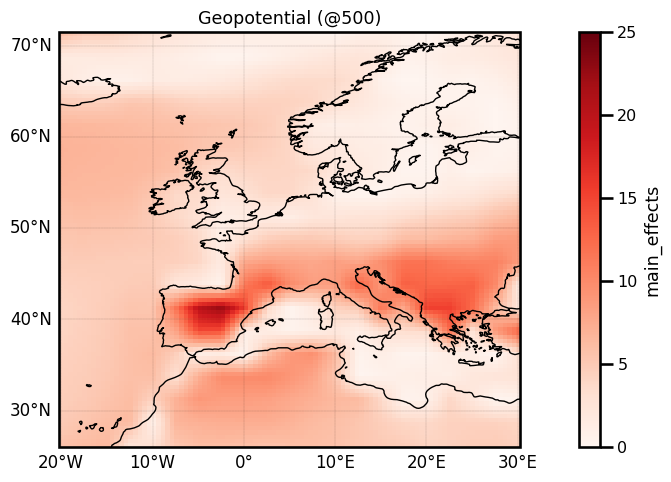

In [19]:
variable_name = "Geopotential (@500)"
covariate = "z500"
effects = "main_effects"
plot_maps(covariate, variable_name, effects)

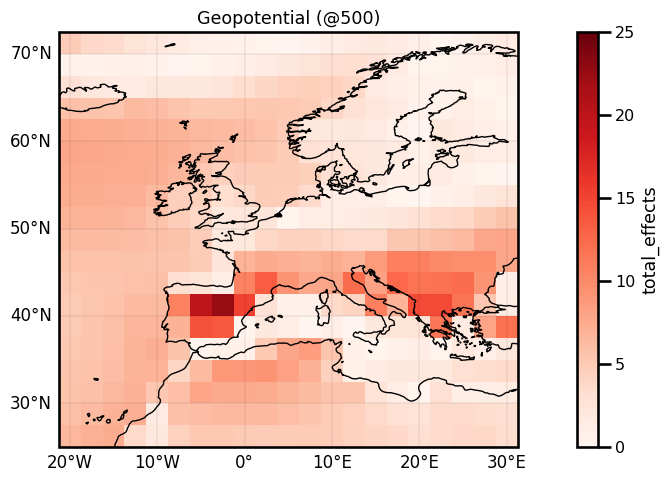

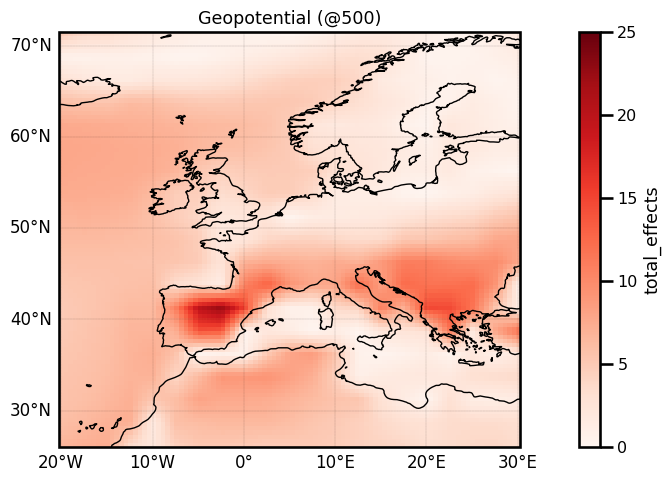

In [20]:
variable_name = "Geopotential (@500)"
covariate = "z500"
effects = "total_effects"
plot_maps(covariate, variable_name, effects)

In [21]:
def plot_maps_gradient(covariate, variable_name):

    # plot weights
    ds_subset = ds["grad_mean"].sel(covariate=covariate).mean("model")
    plot_pcolormesh(
        ds_subset, variable=variable_name, vmin=-2.0, vmax=2, cmap="seismic"
    )

    # interpolate
    ds_subset = ds_subset.interp(
        lon=np.linspace(ds_subset.lon.values.min(), ds_subset.lon.values.max(), 100),
        lat=np.linspace(ds_subset.lat.values.min(), ds_subset.lat.values.max(), 100),
        method="linear",
    )

    plot_imshow(
        ds_subset, variable_name, vmin=-2.0, vmax=2.0, cmap="seismic", num_levels=None
    );

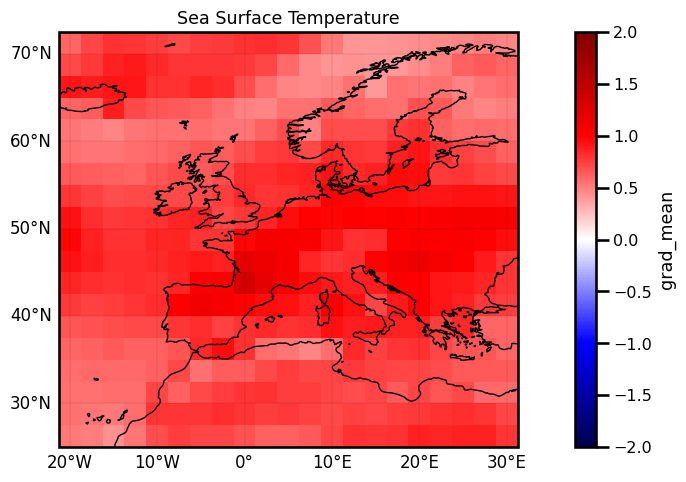

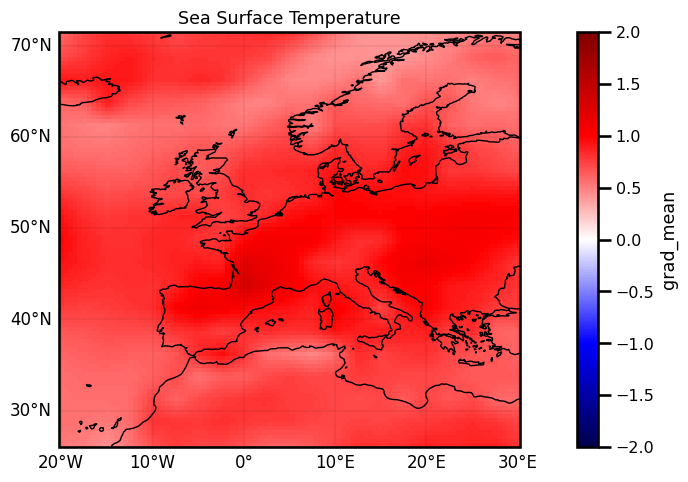

In [22]:
variable_name = "Sea Surface Temperature"
covariate = "sst"
plot_maps_gradient(covariate, variable_name)

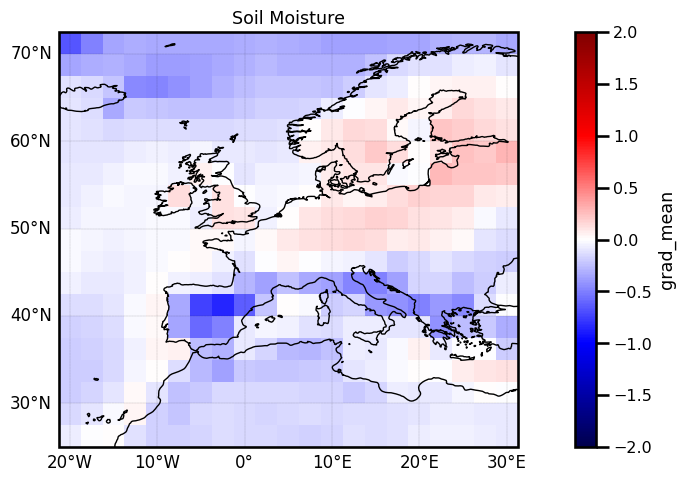

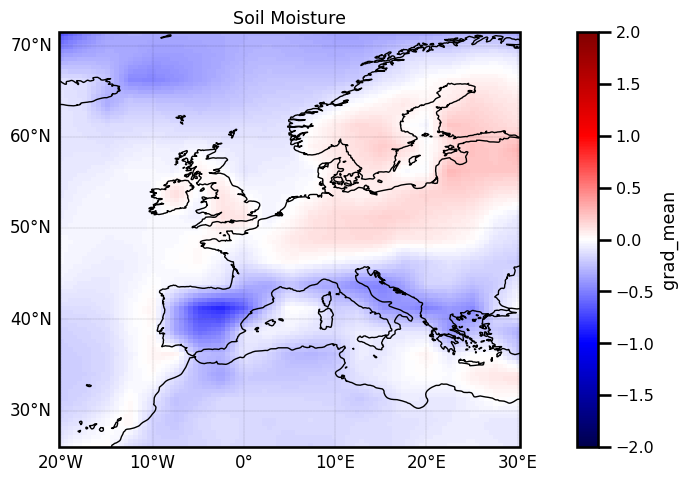

In [23]:
variable_name = "Soil Moisture"
covariate = "sm"
plot_maps_gradient(covariate, variable_name)

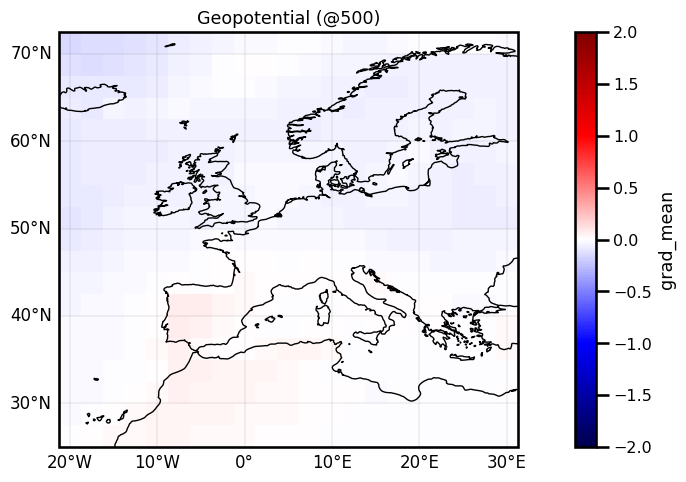

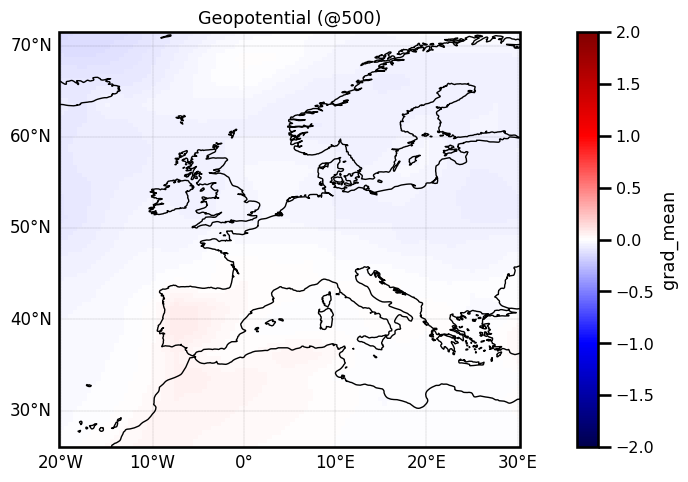

In [24]:
variable_name = "Geopotential (@500)"
covariate = "z500"
plot_maps_gradient(covariate, variable_name)

## Things to Do


* Standardize Input/Output Data (see [sklearn.preprocessing](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing))
* Find the Best Parameters with Cross Validation
* Choose a Better Linear Model ([LASSO](https://scikit-learn.org/stable/modules/linear_model.html#lasso), [LARS](https://scikit-learn.org/stable/modules/linear_model.html#least-angle-regression), [Elastic-Net](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net), [Generalized Linear Model](https://scikit-learn.org/stable/modules/linear_model.html#generalized-linear-models), [Quantile Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.QuantileRegressor.html#sklearn.linear_model.QuantileRegressor))